In [1]:
from __future__ import print_function
from __future__ import division

import pdb
import sys
import os
import numpy as np
import scipy.optimize as opt
import scipy.io as sio
import scipy.special as spf
import yaml

## import diffrantion integral solver from Optics folder
work_dir = os.getcwd()
date_dir = os.path.split(work_dir)[0]
optics_folder = os.path.join(date_dir, 'Optics')
sys.path.append(optics_folder)
sys.path.append(date_dir)
import diffraction_int as diffi
import fibonacci as fib


## Import field functions
field_module_folder = os.path.join(date_dir, 'field_functions')             
sys.path.append(field_module_folder)
import far_fields as fi

## Read parameter file to obtain fields
stream = open('param.yaml','r')
parameters = yaml.load(stream)


## plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# mpl.rcParams['text.usetex'] = True

## colorbar stuff 
from mpl_toolkits import axes_grid1

# import eqm_slns as osc

## analytic image functions
# import analytic_intensity_functions_xyz as imf

## dipole moments as functions of separation, not pulled from param file
# import p_of_d_genOr as pod

# pretty fitting
# import lmfit as lf

import anal_foc_diff_fields as afi


## Import physical constants
full_path_to_constant_yaml = os.path.join(date_dir,'physical_constants.yaml')
opened_constant_file = open(full_path_to_constant_yaml,'r')
constants = yaml.load(opened_constant_file)
e = constants['physical_constants']['e']
c = constants['physical_constants']['c']  # charge of electron in statcoloumbs
hbar =constants['physical_constants']['hbar']
nm = constants['physical_constants']['nm']
n_a = constants['physical_constants']['nA']   # Avogadro's number
# Z_o = 376.7303 # impedence of free space in ohms (SI)

## System background
n_b = parameters['general']['background_ref_index']
eps_b = n_b**2.

a = parameters['plasmon']['radius']
#######################################################################
## simulated image 
sensor_size = 4000*nm
# height = 2*mm  # also defines objective lens focal length 
height = 2e6*nm
resolution = 100  # image grid resolution

norm_style = 'per fig'  # 'per fig' or 'across figs'

show_or_save = 'show'
# show_or_save = raw_input('( show / save ) figures? ')

file_extension = 'pdf'  # 'pdf' for mest quality

## plot parameters
plot_scale = 1/nm

#######################################################################
## Optics stuff.  

## Build image sensor
eye = diffi.observation_points(
    x_min= -sensor_size/2, 
    x_max= sensor_size/2,
    y_min= -sensor_size/2, 
    y_max= sensor_size/2, 
    points= resolution
    )

## Experimental parameters
magnification = 1
numerical_aperture = 1
max_theta = np.arcsin(numerical_aperture) # defines physical aperture size

## numerical parameters for calculation of scattered field
lens_points = 1000

# obj_f = 1.*mm  # still dont know what this is supposed to be
obj_f = height

tube_f = magnification * obj_f

## calculate dipole magnitudes
drive_hbar_omega = parameters['general']['drive_energy']
omega_drive = drive_hbar_omega/hbar  # driving frequency

In [2]:
drive_hbar_omega

2.598

In [3]:
def place_molecules_in_plane(number_of_images):
    pts_per_sensor_width = resolution ## rename global variable because it makes more sense
    XY_coords = np.random.random((2,number_of_images))*sensor_size - sensor_size/2
    molecule_coordinales = XY_coords.T ## (first index coordinate (0:x,1:y), last index frame number)
    return molecule_coordinales

def make_in_plane_cartesien_angles_array(angle_vector):
    x_comp = np.cos(angle_vector)
    y_comp = np.sin(angle_vector)
    z_comp = 0*angle_vector
    unit_vec = np.vstack((x_comp, y_comp, z_comp))

    row_vecs = unit_vec.T # each rwo gives the (x,y) components of the dipole unit vector

    mol_dipole_unit_vec = row_vecs
        
    return mol_dipole_unit_vec


def mb_p_fields(dipole_mag_array, dipole_coordinate_array):
    ''' As of 081418,fixing: currently only treats dipole at origin.'''    
    p = dipole_mag_array
#     print('Inside mb_p_fields, p= ',p)
    bfx = dipole_coordinate_array

    v_rel_obs_x_pts = (eye[1].ravel()[:,None] - bfx.T[0]).T
    v_rel_obs_y_pts = (eye[2].ravel()[:,None] - bfx.T[1]).T
    
    px_fields = np.asarray(afi.E_field(0, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
    py_fields = np.asarray(afi.E_field(np.pi/2, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
    pz_fields = np.zeros(py_fields.shape)
#     print('px_fields.shape=',px_fields.shape)
    ## returns [Ex, Ey, Ez] for dipoles oriented along cart units
    
    Ex = p[:,0,None]*px_fields[0] + p[:,1,None]*py_fields[0] + p[:,2,None]*pz_fields[0]
    Ey = p[:,0,None]*px_fields[1] + p[:,1,None]*py_fields[1] + p[:,2,None]*pz_fields[1]
    Ez = p[:,0,None]*px_fields[2] + p[:,1,None]*py_fields[2] + p[:,2,None]*pz_fields[2]

    return np.array([Ex,Ey,Ez])

In [4]:
number_of_molecules = 300
def make_fields(
    molecule_locations_in_plane=(np.array([[1,0]])*np.ones((number_of_molecules,2))*150*nm),
    molecule_angles=np.linspace(0,2*np.pi,number_of_molecules), ## default
    plas_orientation=[0,1,0] #pi
    ):

    if molecule_locations_in_plane.shape[0] != molecule_angles.shape[0]:
        print('first two inputs must have same length: shape[0] = number of molecules')  
        return None

    number_of_molecules = molecule_locations_in_plane.shape[0]
        
    plas_orientation = np.array(plas_orientation)
    if plas_orientation.shape != (3,):
        print('not ready for multiple plasmon orientatnions')  
        return None
    # define angles
    # number_of_molecules = 5
    # ordered_angles = np.linspace(0,2*np.pi,number_of_molecules)

    ## plas-mol separation
#     d = dnm*nm
    ## make seperation vectors
    p0_hat = make_in_plane_cartesien_angles_array(molecule_angles)

    bf_x0 = molecule_locations_in_plane
    # np.array([[1,0,0]])*np.ones((number_of_molecules,2))*d
    bf_x1 = np.zeros((number_of_molecules,2)) ## probably not needed

    ## assuming plasmon at orgin: d is equal to the molecule mosition bf_x0, 
    ##... but we need to add a z component to the array
    bf_d = np.hstack((bf_x0,np.zeros((molecule_locations_in_plane.shape[0],1))))
#     bf_d = bf_x0
#     print('bf_d = ',bf_d )
    # Calcualte p0 from coupled equations of motion
    bf_p0 = define_p0_array(p0_hat, plas_orientation, bf_d)
    bf_p1 = define_p1_array(p0_hat, plas_orientation, bf_d)
    
    print('inside make_fields(): bf_p0 = ',bf_p0)
    print('inside make_fields(): bf_p1 = ',bf_p1)
    
    E0 = mb_p_fields(bf_p0, bf_x0)
    E1 = mb_p_fields(bf_p1, bf_x1)
    E_tot = E0 + E1

    return np.array([E0, E1, E_tot]) 
        
def fields_to_hist(field_array):
    E0 = field_array[0]
    E1 = field_array[1]
    
    mol_images = (np.abs(E0[0])**2.+np.abs(E0[1])**2.+np.abs(E0[2])**2.)
    plas_images = (np.abs(E1[0])**2.+np.abs(E1[1])**2.+np.abs(E1[2])**2.)
    images = (
        np.abs(E1[0]+E0[0])**2.
        +
        np.abs(E1[1]+E0[1])**2.
        +
        np.abs(E1[2]+E0[2])**2.
        )

    Ix = np.abs(E1[0]+E0[0])**2.    
    Iy = np.abs(E1[1]+E0[1])**2.    

    Px = np.sum(Ix,axis=-1)
    Py = np.sum(Iy,axis=-1)

    normed_Px = Px - np.min(Px)
    normed_Py = Py - np.min(Py)

    observed_angles = np.arctan(normed_Py**0.5/normed_Px**0.5)
    print(observed_angles)
    plt.figure()
    plt.hist(observed_angles,25)
    ticks = [0,np.pi/4,np.pi/2]
    tick_labels = [0, r'$\pi/4$',r'$\pi/2$']
    plt.xticks(ticks, tick_labels)
#     plt.yticks([0,np.pi/16,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2], 
#               [r'$0$', r'$\pi/16$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])
    plt.ylabel('molecule images')
    plt.xlabel('actual angle')
#     if np.all(plas_orientation==[1,0,0]):
#         plas_unit_sym = r'\hat{x}'
#     elif np.all(plas_orientation==[0,1,0]):
#         plas_unit_sym = r'$\hat{y}$'
#     else: plas_unit_sym = '{}'.format(plas_orientation)
#     plt.title('d = {0} nm, '.format(dnm)+r'$\hat{p}_\mathrm{plas} = $'+plas_unit_sym)
    plt.show()
    return None

In [5]:
def fields_to_mol_map(field_array):
    mol_E = field_array[0]
#     E1 = field_array[1]
    
    Ix = np.abs(mol_E[0])**2.    
    Iy = np.abs(mol_E[1])**2.    

    Px = np.sum(Ix,axis=-1)
    Py = np.sum(Iy,axis=-1)

    normed_Px = Px - np.min(Px)
    normed_Py = Py - np.min(Py)
    
    ordered_angles = np.linspace(0,2*np.pi,number_of_molecules)
    observed_angles = np.arctan(normed_Py**0.5/normed_Px**0.5)
    
    plt.figure()
    plt.plot(ordered_angles,observed_angles)
    ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi, 2*np.pi]
    tick_labels = [0, r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$', r'$\pi$',r'$2\pi$']
    plt.xticks(ticks, tick_labels)
    plt.yticks([0,np.pi/16,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2], 
              [r'$0$', r'$\pi/16$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])
    plt.ylabel('observed angle')
    plt.xlabel('actual angle')
    plt.show()

In [6]:
# mol_E, plas_E, tot_E = fields_to_plot

# for i in np.arange(number_of_molecules):
#     plt.figure()
#     plt.pcolor(
#         eye[1]*1e7,
#         eye[2]*1e7,
#         (np.abs(mol_E[0,i])**2.+np.abs(mol_E[1,i])**2.+np.abs(mol_E[2,i])**2.).reshape(eye[1].shape)
#         )
#     plt.title('molecule')
#     plt.colorbar()

#     plt.figure()
#     plt.pcolor(
#         eye[1]*1e7,
#         eye[2]*1e7,
#         (np.abs(plas_E[0,i])**2.+np.abs(plas_E[1,i])**2.+np.abs(plas_E[2,i])**2.).reshape(eye[1].shape)
#         )
#     plt.title('plasmon')
#     plt.colorbar()

#     plt.figure()
#     plt.pcolor(
#         eye[1]*1e7,
#         eye[2]*1e7,
#         (np.abs(plas_E[0,i]+mol_E[0,i])**2.
#          +
#          np.abs(plas_E[1,i]+mol_E[1,i])**2.
#          +
#          np.abs(plas_E[2,i]+mol_E[2,i])**2.
#          ).reshape(eye[1].shape)
#         )
#     plt.title('both')
#     plt.colorbar()
#     plt.show()


Implementing generalization of coupled dipole solution, 09/20/18

In [7]:
import coupled_dipoles as cp 

polarizability reduced by factor of 1
coupling scaled up by by factor of 1


09/21/18

In [8]:
locations = diffi.observation_points(x_min=50, x_max=500, y_min=50, y_max=500, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

In [9]:
d = locations*nm
p0, p1 = cp.dipole_magnitudes(mol_angle=0, plas_angle=np.pi/2, d_col=d, E_d_angle=None)
mol_E = mb_p_fields(dipole_mag_array=p0, dipole_coordinate_array=d) 
plas_E = mb_p_fields(dipole_mag_array=p1, dipole_coordinate_array=np.zeros(d.shape))

inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607


In [10]:
p1.shape

(121, 3)

In [11]:
d.shape

(121, 3)

In [12]:
# p0_unc, = cp.uncoupled_p0(mol_angle=0, d_col=d[0,None], E_d_angle=None)
p0_unc, = cp.uncoupled_p0(mol_angle=0, d_col=d[0][None,:], E_d_angle=None)
p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=np.zeros(d[0][None,:].shape))

inside anal_foc_diff_fields.E_field, 
 xi.shape =  (1, 10000) 
 y.shape =  (1, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (1, 10000) 
 y.shape =  (1, 10000) k =  131659.64511607


In [13]:
p0_unc_E.shape

(3, 1, 10000)

In [14]:
E0 = mol_E 
E1 = plas_E
images = (
    np.abs(E1[0]+E0[0])**2.
    +
    np.abs(E1[1]+E0[1])**2.
    +
    np.abs(E1[2]+E0[2])**2.
    )

unc_images = (
    np.abs(p0_unc_E[0])**2.
    +
    np.abs(p0_unc_E[1])**2.
    +
    np.abs(p0_unc_E[2])**2.
    )

Ix = np.abs(E1[0]+E0[0])**2.    
Iy = np.abs(E1[1]+E0[1])**2.  
I_leaky = np.abs(p0_unc_E[1])**2.

Px = np.sum(Ix,axis=-1) / sensor_size**2.
Py = np.sum(Iy,axis=-1) / sensor_size**2.
P_leaky = np.sum(I_leaky,axis=-1) / sensor_size**2.

# normed_Px = Px - P_leaky
# normed_Py = Py - P_leaky
normed_Px = Px - np.min(Py)
normed_Py = Py - np.min(Py)

normed_observed_angles = np.arctan(normed_Py**0.5/normed_Px**0.5)

In [15]:
P_leaky

array([2.80667692e-08])

1.9434548749648503e-07 1.4369363551896598e-07


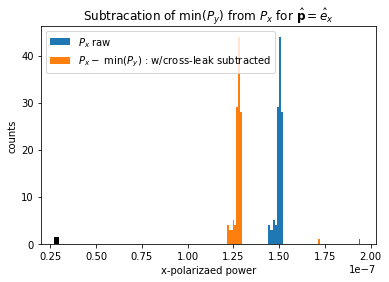

In [16]:
plt.hist(Px,50, label=r'$P_x$ raw')
print(np.max(Px), np.min(Px))
plt.hist(normed_Px,50, label=r'$P_x -$ min$(P_y)$ : w/cross-leak subtracted')
plt.xlabel(r'x-polarizaed power')
plt.ylabel(r'counts')
plt.title(r'Subtracation of min($P_y$) from $P_x$ for $\hat{\mathbf{p}} = \hat{e}_x$')
plt.legend(loc='best')
plt.plot([P_leaky,P_leaky],[0,1],color='k',lw=5)

2.9449171278352967e-07 2.2242573992115588e-08


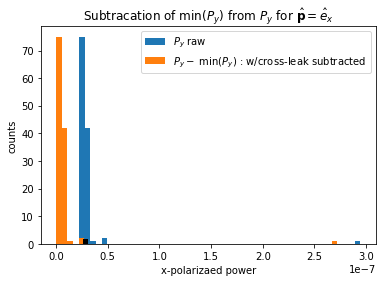

In [17]:
plt.hist(Py, 50, label=r'$P_y$ raw')
print(np.max(Py), np.min(Py))
plt.hist(normed_Py, 50, label=r'$P_y -$ min$(P_y)$ : w/cross-leak subtracted')
plt.legend()
plt.xlabel(r'x-polarizaed power')
plt.ylabel(r'counts')
plt.title(r'Subtracation of min($P_y$) from $P_y$ for $\hat{\mathbf{p}} = \hat{e}_x$')
plt.legend(loc='best')
plt.plot([P_leaky,P_leaky],[0,1],color='k',lw=5)

In [18]:
(np.min(Py))

2.2242573992115588e-08

In [19]:
np.argmin(Py)

25

In [20]:
print(d.shape,Py.shape)

(121, 3) (121,)


Text(0.5,1,'Image with minimum $P_y$')

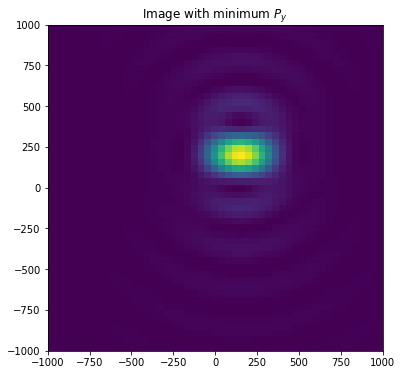

In [21]:
plt.figure(figsize=(6,6))
plt.pcolor(eye[1]*1e7,eye[2]*1e7,images[np.argmin(Py)].reshape(eye[2].shape))
plt.xlim((-1000,1000))
plt.ylim((-1000,1000))
plt.title(r'Image with minimum $P_y$')
# plt.axis('equal')

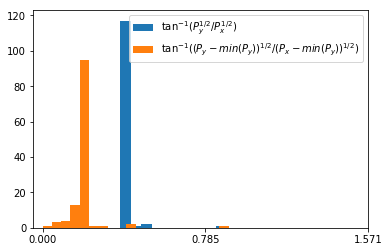

In [22]:
unnormed_observed_angles = np.arctan(Py**0.5/Px**0.5)
# observed_angles = np.arctan(normed_Py**0.5/normed_Px**0.5)
# plt.hist(observed_angles)
plt.hist(unnormed_observed_angles,label=r'$\tan^{-1}(P_y^{1/2}/P_x^{1/2})$')
plt.hist(normed_observed_angles,20,label=r'$\tan^{-1}((P_y-min(P_y))^{1/2}/(P_x-min(P_y))^{1/2})$')
# plt.xticks(np.array([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]))
plt.xticks(np.array([0,np.pi/4,np.pi/2]))
plt.legend()

Am I subtracting the right minimum power?

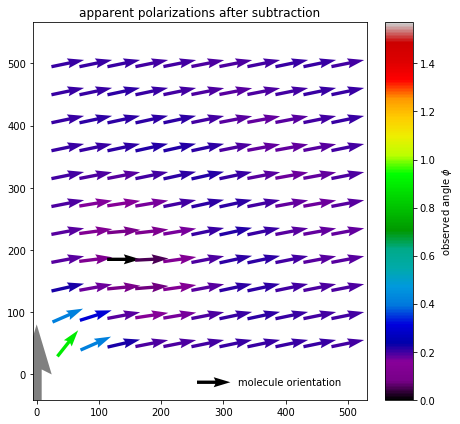

In [23]:
x_plot = locations[:,0]
y_plot = locations[:,1]
cmap = mpl.cm.nipy_spectral

fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(6.5,6), 
                                   gridspec_kw = {'width_ratios':[6, 0.5]}
                                  )

quiv = ax0.quiver(x_plot, y_plot, np.cos(normed_observed_angles),
                  np.sin(normed_observed_angles), 
                  normed_observed_angles,
                  cmap=cmap,
                  clim = [0, np.pi/2], 
                  width=0.01,
                  scale=10,
        #            scale_units='width',
                  pivot='mid'
                  )
qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', labelpos='E',
                   coordinates='figure')

plas_mark = ax0.quiver(0, 0, 0,.3, color='grey',
#                        marker='o',
#                        s=2000
                       width=0.03,
                       scale=1,
                       units='width',
                       pivot='mid'
                      )
ax0.axis('equal')
ax0.set_xlim([-25, 550])
ax0.set_ylim([-25, 550])
ax0.set_title('apparent polarizations after subtraction')

norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'observed angle $\phi$')

fig.tight_layout()

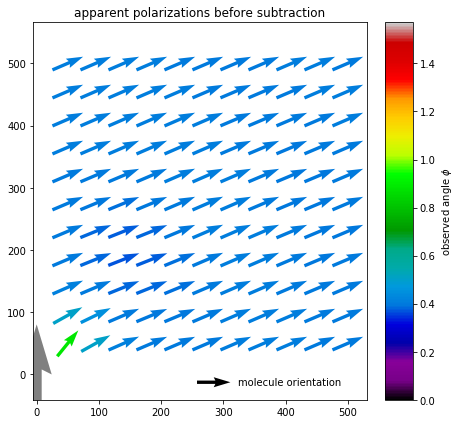

In [24]:

fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(6.5,6), 
                                   gridspec_kw = {'width_ratios':[6, 0.5]}
                                  )

quiv = ax0.quiver(x_plot, y_plot, np.cos(unnormed_observed_angles),
                np.sin(unnormed_observed_angles), 
                   unnormed_observed_angles,
                   cmap=cmap,
                   clim = [0, np.pi/2], 
                   width=0.01,
                   scale=10,
        #            scale_units='width',
                   pivot='mid'
                  )
qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', labelpos='E',
                   coordinates='figure')

plas_mark = ax0.quiver(0, 0, 0,.3, color='grey',
#                        marker='o',
#                        s=2000
                       width=0.03,
                       scale=1,
                       units='width',
                       pivot='mid'
                      )
ax0.axis('equal')
ax0.set_xlim([-25, 550])
ax0.set_ylim([-25, 550])
ax0.set_title('apparent polarizations before subtraction')

norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'observed angle $\phi$')

fig.tight_layout()

In [25]:
print(np.min(unnormed_observed_angles),np.max(unnormed_observed_angles),'\n',
     np.pi/8,np.pi/8*3)

0.37380928775790245 0.8885616722531187 
 0.39269908169872414 1.1780972450961724


In [26]:
unnormed_observed_angles.reshape((11,11))

array([[0.88856167, 0.50816329, 0.41319303, 0.40004072, 0.39936154,
        0.40154325, 0.40406515, 0.40576102, 0.4063435 , 0.40618578,
        0.40583023],
       [0.50896372, 0.45154954, 0.40108003, 0.38540698, 0.38630707,
        0.39328015, 0.40064956, 0.40555907, 0.40740263, 0.40711888,
        0.4061378 ],
       [0.41519126, 0.40441777, 0.38329487, 0.37380929, 0.3782908 ,
        0.38949965, 0.40030202, 0.40694192, 0.40891944, 0.40788108,
        0.40610365],
       [0.403176  , 0.39292011, 0.38056148, 0.37632197, 0.38270996,
        0.39413312, 0.40414738, 0.40940197, 0.40984605, 0.40763313,
        0.40538971],
       [0.40314268, 0.39645465, 0.39032561, 0.38972236, 0.3952358 ,
        0.40302123, 0.40881949, 0.41057854, 0.40886036, 0.40596228,
        0.40415481],
       [0.40496007, 0.40294273, 0.40176696, 0.40290982, 0.40596205,
        0.40894233, 0.40996117, 0.40849892, 0.40568908, 0.403487  ,
        0.40313301],
       [0.40615767, 0.40690966, 0.40789034, 0.40876213, 0.

In [27]:
phase_diff = np.arccos(np.real(p0/p1)/np.abs(p0/p1))

/Users/chair/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


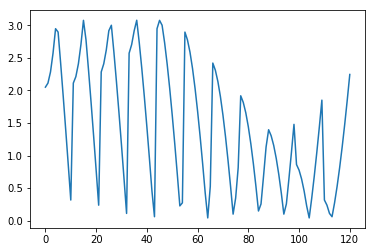

In [28]:
plt.plot(phase_diff[:,0])

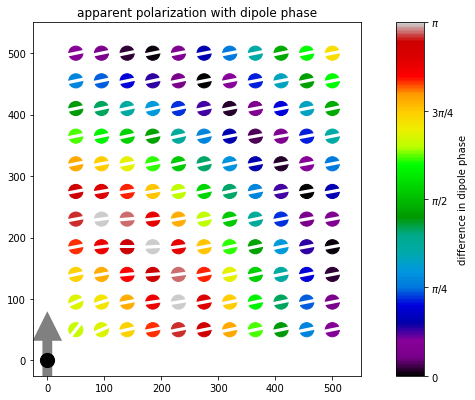

In [29]:
fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(7,6.5), 
                                   gridspec_kw = {'width_ratios':[6, 0.5]}
                                  )
scat_color = phase_diff[:,0]

ax0.scatter(x_plot, y_plot, c=scat_color, s=200,
           cmap=cmap,
           clim = [0, np.pi], 
#            width=0.01,
#            scale=10,
#            scale_units='width',
#            pivot='mid'
          )

ax0.set_xlim([-25, 550])
ax0.set_ylim([-25, 550])

norm = mpl.colors.Normalize(vmin=0, vmax=np.pi)
cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm,
                                orientation='vertical',
                                ticks=[0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],
                                )
# ax_cbar.set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
# cb1.set_ticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
cb1.set_ticklabels([r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'])
cb1.set_label(r'difference in dipole phase')
ax0.set_title(r'apparent polarization with dipole phase')


plas_arrow = ax0.quiver(0, 0, 0,.3, color='grey',
#                        marker='o',
#                        s=2000
                       width=0.03,
                       scale=1,
                       units='width',
                       pivot='mid',
                       headlength=3,
                       headaxislength=3
                      )
plas_dot = ax0.scatter(0,0,color='k',s=200)

quiv = ax0.quiver(x_plot, y_plot, np.cos(normed_observed_angles),np.sin(normed_observed_angles), 
                color='white',
#                    cmap='inferno',
#                    clim = [0, np.pi/2], 
                   width=0.01,
                   scale=12,
        #            scale_units='width',
                   pivot='mid',
#                   linewidth=100.,
                  headaxislength=0.0,
                  headlength=0.0
                  )
# qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', labelpos='E',
#                    coordinates='figure', color='k' )

# fig.tight_layout()

# plt.colorbar(ticks=[0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])

In [30]:
print(
    p0.shape,
    d.shape,
locations.shape)

(121, 3) (121, 3) (121, 3)


In [31]:
locations = diffi.observation_points(x_min=50, x_max=500, y_min=50, y_max=500, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

d = locations*nm
p0, p1 = cp.dipole_magnitudes(mol_angle=np.pi/2, plas_angle=np.pi/2, d_col=d, E_d_angle=None)
mol_E = mb_p_fields(dipole_mag_array=p0, dipole_coordinate_array=d) 
plas_E = mb_p_fields(dipole_mag_array=p1, dipole_coordinate_array=np.zeros(d.shape))

E0 = mol_E 
E1 = plas_E
images = (
    np.abs(E1[0]+E0[0])**2.
    +
    np.abs(E1[1]+E0[1])**2.
    +
    np.abs(E1[2]+E0[2])**2.
    )

# mol_images = (
#     np.abs(E0[0])**2.
#     +
#     np.abs(E0[1])**2.
#     +
#     np.abs(E0[2])**2.
#     )
# plas_images = (
#     np.abs(E1[0])**2.
#     +
#     np.abs(E1[1])**2.
#     +
#     np.abs(E1[2])**2.
#     )


unc_images = (
    np.abs(p0_unc_E[0])**2.
    +
    np.abs(p0_unc_E[1])**2.
    +
    np.abs(p0_unc_E[2])**2.
    )

Ix = np.abs(E1[0]+E0[0])**2.    
Iy = np.abs(E1[1]+E0[1])**2.  

mol_Ix = np.abs(E0[0])**2.    
mol_Iy = np.abs(E0[1])**2.  
plas_Ix = np.abs(E1[0])**2.    
plas_Iy = np.abs(E1[1])**2.  

I_leak = np.abs(p0_unc_E[1])**2.

Px = np.sum(Ix,axis=-1) / sensor_size**2.
Py = np.sum(Iy,axis=-1) / sensor_size**2.
mol_Px = np.sum(mol_Ix,axis=-1) / sensor_size**2.
mol_Py = np.sum(mol_Iy,axis=-1) / sensor_size**2.
P_leaky = np.sum(I_leak,axis=-1) / sensor_size**2.

# normed_Px = Px - P_leaky
# normed_Py = Py - P_leaky
normed_Px = Px - np.min(Px)
normed_Py = Py - np.min(Px)


y_dip_observed_angles = np.arctan(normed_Py**0.5/normed_Px**0.5)
y_dip_mol_angle = np.arctan(mol_Py**0.5/mol_Px**0.5)

inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607


/Users/chair/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: divide by zero encountered in true_divide


3.001788654761925e-08 1.6469901693315515e-08
1.5609658032692373e-07 8.192056204752572e-08


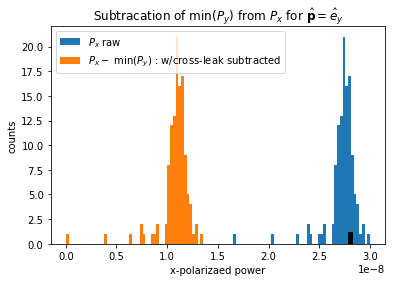

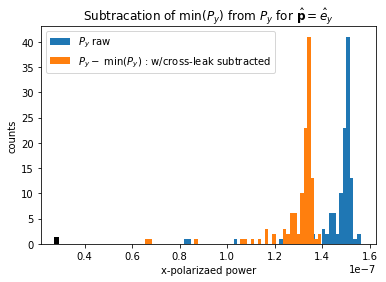

In [32]:
plt.hist(Px,50, label=r'$P_x$ raw')
print(np.max(Px), np.min(Px))
plt.hist(normed_Px,50, label=r'$P_x -$ min$(P_y)$ : w/cross-leak subtracted')
plt.xlabel(r'x-polarizaed power')
plt.ylabel(r'counts')
plt.title(r'Subtracation of min($P_y$) from $P_x$ for $\hat{\mathbf{p}} = \hat{e}_y$')
plt.legend(loc='best')
plt.plot([P_leaky,P_leaky],[0,1],color='k',lw=5)

plt.figure()
plt.hist(Py, 50, label=r'$P_y$ raw')
print(np.max(Py), np.min(Py))
plt.hist(normed_Py, 50, label=r'$P_y -$ min$(P_y)$ : w/cross-leak subtracted')
plt.legend()
plt.xlabel(r'x-polarizaed power')
plt.ylabel(r'counts')
plt.title(r'Subtracation of min($P_y$) from $P_y$ for $\hat{\mathbf{p}} = \hat{e}_y$')
plt.legend(loc='best')
plt.plot([P_leaky,P_leaky],[0,1],color='k',lw=5)

In [33]:
y_dip_unnormed_observed_angles = np.arctan(Py**0.5/Px**0.5)

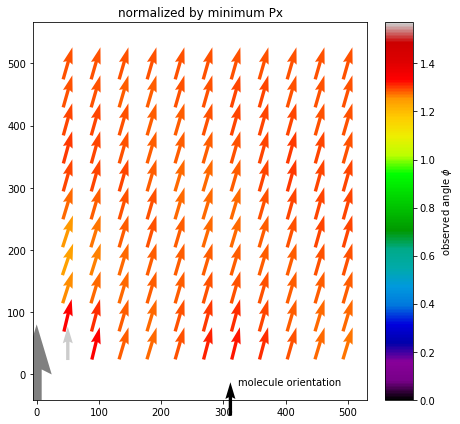

In [34]:
x = locations[:,0]
y = locations[:,1]
cmap = mpl.cm.nipy_spectral

fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(6.5,6), 
                                   gridspec_kw = {'width_ratios':[6, 0.5]}
                                  )

quiv = ax0.quiver(x, y, np.cos(y_dip_observed_angles),np.sin(y_dip_observed_angles), 
                   y_dip_observed_angles,
                   cmap=cmap,
                   clim = [0, np.pi/2], 
                   width=0.01,
                   scale=10,
        #            scale_units='width',
                   pivot='mid'
                  )
qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', 
                       labelpos='E',
                       coordinates='figure',
                      angle=90)

plas_mark = ax0.quiver(0, 0, 0,.3, color='grey',
#                        marker='o',
#                        s=2000
                       width=0.03,
                       scale=1,
                       units='width',
                       pivot='mid'
                      )
# plas_mark_label = ax_cbar.quiverkey(plas_mark, 0.4, 0.005, 2, r'molecule orientation', labelpos='E',
#                    coordinates='figure')
ax0.axis('equal')
ax0.set_xlim([-25, 550])
ax0.set_ylim([-25, 550])
ax0.set_title(r'normalized by minimum Px')

norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'observed angle $\phi$')

fig.tight_layout()

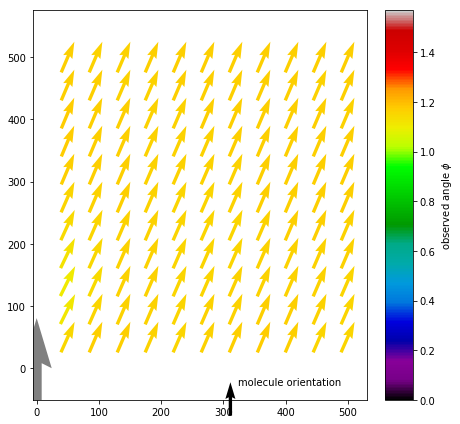

In [35]:
x = locations[:,0]
y = locations[:,1]
cmap = mpl.cm.nipy_spectral

fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(6.5,6), 
                                   gridspec_kw = {'width_ratios':[6, 0.5]}
                                  )

quiv = ax0.quiver(x, y, np.cos(y_dip_unnormed_observed_angles),np.sin(y_dip_unnormed_observed_angles), 
                   y_dip_unnormed_observed_angles,
                   cmap=cmap,
                   clim = [0, np.pi/2], 
                   width=0.01,
                   scale=10,
        #            scale_units='width',
                   pivot='mid'
                  )
qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', 
                       labelpos='E',
                       coordinates='figure',
                      angle=90)

plas_mark = ax0.quiver(0, 0, 0,.3, color='grey',
#                        marker='o',
#                        s=2000
                       width=0.03,
                       scale=1,
                       units='width',
                       pivot='mid'
                      )
ax0.axis('equal')
ax0.set_xlim([-25, 550])
ax0.set_ylim([-25, 550])

norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'observed angle $\phi$')

fig.tight_layout()

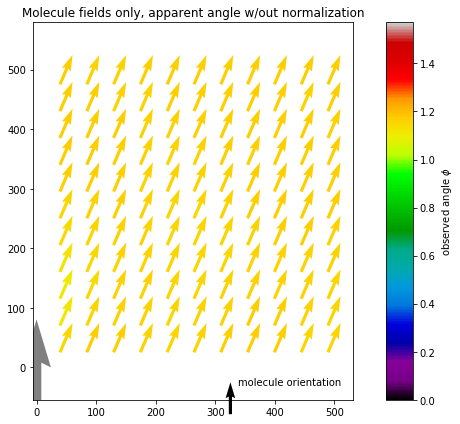

In [36]:
x = locations[:,0]
y = locations[:,1]
cmap = mpl.cm.nipy_spectral

fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(6.5,6), 
                                   gridspec_kw = {'width_ratios':[6, 0.5]}
                                  )

quiv = ax0.quiver(x, y, np.cos(y_dip_mol_angle),np.sin(y_dip_mol_angle), 
                   y_dip_unnormed_observed_angles,
                   cmap=cmap,
                   clim = [0, np.pi/2], 
                   width=0.01,
                   scale=10,
        #            scale_units='width',
                   pivot='mid'
                  )
qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', 
                       labelpos='E',
                       coordinates='figure',
                      angle=90)

plas_mark = ax0.quiver(0, 0, 0,.3, color='grey',
#                        marker='o',
#                        s=2000
                       width=0.03,
                       scale=1,
                       units='width',
                       pivot='mid'
                      )
ax0.axis('equal')
ax0.set_xlim([-25, 550])
ax0.set_ylim([-25, 550])
ax0.set_title(r'Molecule fields only, apparent angle w/out normalization')

norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'observed angle $\phi$')

fig.tight_layout()

(array([13., 19., 17., 17., 15., 12., 13.,  8.,  5.,  2.]),
 array([1.16416733, 1.16442605, 1.16468477, 1.16494349, 1.16520221,
        1.16546093, 1.16571965, 1.16597836, 1.16623708, 1.1664958 ,
        1.16675452]),
 <a list of 10 Patch objects>)

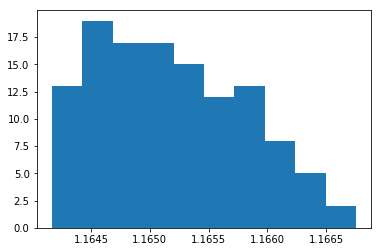

In [37]:
plt.hist(y_dip_mol_angle)

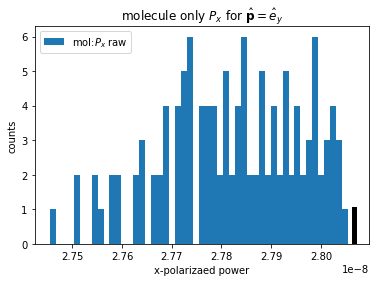

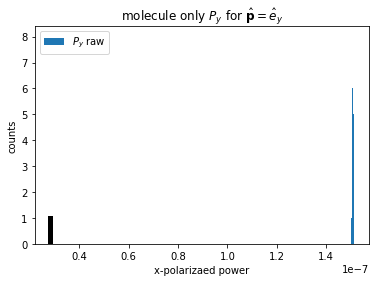

In [38]:
plt.hist(mol_Px,50, label=r'mol:$P_x$ raw')
# print(np.max(Px), np.min(Px))
# plt.hist(normed_Px,50, label=r'$P_x -$ min$(P_y)$ : w/cross-leak subtracted')
plt.xlabel(r'x-polarizaed power')
plt.ylabel(r'counts')
plt.title(r'molecule only $P_x$ for $\hat{\mathbf{p}} = \hat{e}_y$')
plt.legend(loc='best')
plt.plot([P_leaky,P_leaky],[0,1],color='k',lw=5)

plt.figure()
plt.hist(mol_Py, 50, label=r'$P_y$ raw')
# print(np.max(Py), np.min(Py))
# plt.hist(normed_Py, 50, label=r'$P_y -$ min$(P_y)$ : w/cross-leak subtracted')
plt.legend()
plt.xlabel(r'x-polarizaed power')
plt.ylabel(r'counts')
plt.title(r'molecule only $P_y$ for $\hat{\mathbf{p}} = \hat{e}_y$')
plt.legend(loc='best')
plt.plot([P_leaky,P_leaky],[0,1],color='k',lw=5)
# plt.xlim([0,0.6])

(0, 0.6)

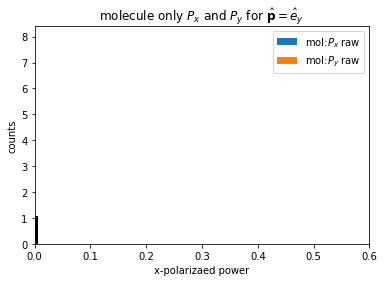

In [39]:
plt.hist(mol_Px,50, label=r'mol:$P_x$ raw')
# print(np.max(Px), np.min(Px))
# plt.hist(normed_Px,50, label=r'$P_x -$ min$(P_y)$ : w/cross-leak subtracted')
plt.xlabel(r'x-polarizaed power')
plt.ylabel(r'counts')
# plt.title(r'molecule only $P_x$ for $\hat{\mathbf{p}} = \hat{e}_y$')
plt.legend(loc='best')
plt.plot([P_leaky,P_leaky],[0,1],color='k',lw=5)

# plt.figure()
plt.hist(mol_Py, 50, label=r'mol:$P_y$ raw')
# print(np.max(Py), np.min(Py))
# plt.hist(normed_Py, 50, label=r'$P_y -$ min$(P_y)$ : w/cross-leak subtracted')
plt.legend()
plt.xlabel(r'x-polarizaed power')
plt.ylabel(r'counts')
plt.title(r'molecule only $P_x$ and $P_y$ for $\hat{\mathbf{p}} = \hat{e}_y$')
plt.legend(loc='best')
plt.plot([P_leaky,P_leaky],[0,1],color='k',lw=5)
plt.xlim([0,0.6])

zooming in

In [40]:
locations = diffi.observation_points(x_min=50, x_max=500, y_min=50, y_max=500, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

def observe_angles(locations, mol_angle=0, plas_angle=np.pi/2):
    d = locations*nm
    p0, p1 = cp.dipole_magnitudes(mol_angle=mol_angle, plas_angle=plas_angle, d_col=d, E_d_angle=None)
    mol_E = mb_p_fields(dipole_mag_array=p0, dipole_coordinate_array=d) 
    plas_E = mb_p_fields(dipole_mag_array=p1, dipole_coordinate_array=np.zeros(d.shape))

    E0 = mol_E 
    E1 = plas_E

    Ix = np.abs(E1[0]+E0[0])**2.    
    Iy = np.abs(E1[1]+E0[1])**2.  

    mol_Ix = np.abs(E0[0])**2.    
    mol_Iy = np.abs(E0[1])**2.  
    plas_Ix = np.abs(E1[0])**2.    
    plas_Iy = np.abs(E1[1])**2.  

    I_leak = np.abs(p0_unc_E[1])**2.

    Px = np.sum(Ix,axis=-1) / sensor_size**2.
    Py = np.sum(Iy,axis=-1) / sensor_size**2.
    mol_Px = np.sum(mol_Ix,axis=-1) / sensor_size**2.
    mol_Py = np.sum(mol_Iy,axis=-1) / sensor_size**2.
    P_leaky = np.sum(I_leak,axis=-1) / sensor_size**2.

    # normed_Px = Px - P_leaky
    # normed_Py = Py - P_leaky
    normed_Px = Px - np.min([Px,Py])
    normed_Py = Py - np.min([Px,Py])

    subtracted_observed_angles = np.arctan(normed_Py**0.5/normed_Px**0.5)
    raw_observed_angles = np.arctan(Py**0.5/Px**0.5)
    apparent_mol_angles = np.arctan(mol_Py**0.5/mol_Px**0.5)
    
    return [subtracted_observed_angles, raw_observed_angles, apparent_mol_angles]

In [41]:
def plot_apparent_orientation_map(normed_observed_angles, title_string='apparent polarizations after subtraction'):
    x_plot = locations[:,0]
    y_plot = locations[:,1]
    cmap = mpl.cm.nipy_spectral

    fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(7.5,6), 
                                       gridspec_kw = {'width_ratios':[7, 0.5]}
                                      )

    quiv = ax0.quiver(x_plot, y_plot, np.cos(normed_observed_angles),
                      np.sin(normed_observed_angles), 
                      normed_observed_angles,
                      cmap=cmap,
                      clim = [0, np.pi/2], 
                      width=0.0075,
                      scale=15,
            #            scale_units='width',
                      pivot='mid'
                      )
#     qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', labelpos='E',
#                        coordinates='figure')

    plas_mark = ax0.quiver(0, 5, 0,.3, color='grey',
    #                        marker='o',
    #                        s=2000
                           width=0.02,
                           scale=1.5,
                           units='width',
                           pivot='mid'
                          )
    plas_dot = ax0.scatter(0,0,color='k',s=200)
    
#     ax0.axis('equal')
    ax0.set_xlim([-25, np.max(locations)+25])
    ax0.set_ylim([-25, np.max(locations)+25])
    ax0.set_title(title_string)

    norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

    cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label(r'observed angle $\phi$')
    cb1.set_ticks([0, np.pi/8, np.pi/4, np.pi/8 * 3, np.pi/2])
    cb1.set_ticklabels([r'$0$', r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])

    fig.tight_layout()

In [42]:
locations = diffi.observation_points(x_min=25, x_max=300, y_min=0, y_max=300, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

x_dip_subbed_obs_angles, x_dip_raw_obs_angles, x_dip_raw_mol_obs_angles = observe_angles(
    locations, mol_angle=0, plas_angle=np.pi/2)

inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607


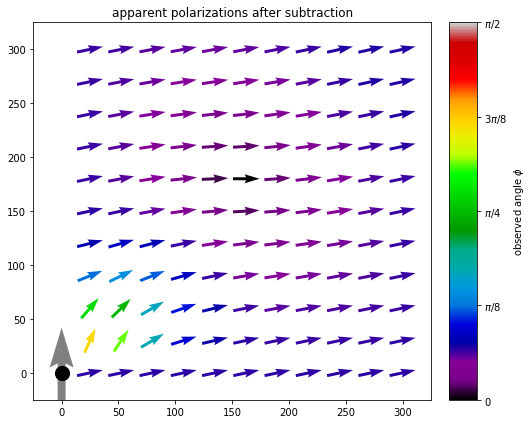

In [43]:
plot_apparent_orientation_map(x_dip_subbed_obs_angles, title_string='apparent polarizations after subtraction')

inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607


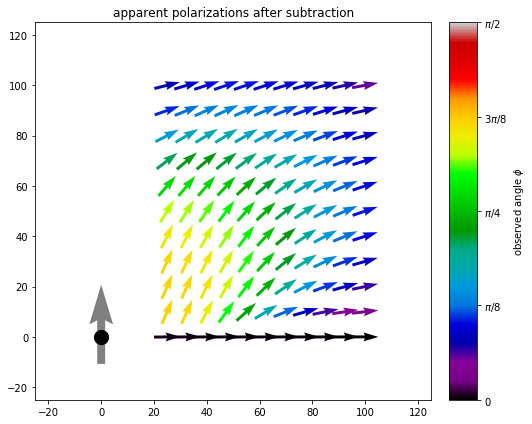

In [44]:
locations = diffi.observation_points(x_min=25, x_max=100, y_min=0, y_max=100, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

x_dip_subbed_obs_angles, x_dip_raw_obs_angles, x_dip_raw_mol_obs_angles = observe_angles(
    locations, mol_angle=0, plas_angle=np.pi/2)

plot_apparent_orientation_map(x_dip_subbed_obs_angles, title_string='apparent polarizations after subtraction')

In [45]:
locations = diffi.observation_points(x_min=25, x_max=300, y_min=0, y_max=300, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
y_dip_subbed_obs_angles, y_dip_raw_obs_angles, y_dip_raw_mol_obs_angles = observe_angles(
    locations, mol_angle=np.pi/2, plas_angle=np.pi/2)

inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (121, 10000) 
 y.shape =  (121, 10000) k =  131659.64511607


/Users/chair/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in true_divide


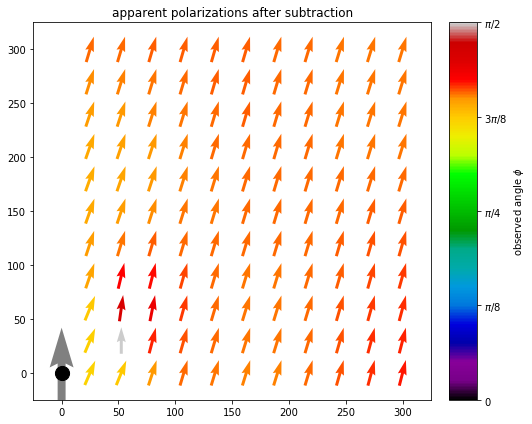

In [46]:
plot_apparent_orientation_map(y_dip_subbed_obs_angles, title_string='apparent polarizations after subtraction')

09/28/18: Moving past my weird subtraction thing to directly using tyhe mapping as Curly is doing

In [48]:
saved_mapping = np.loadtxt('obs_pol_vs_true_angle.txt')
true_ord_angles, obs_ord_angles =  saved_mapping.T

In [49]:
np.argmax(obs_ord_angles)

250

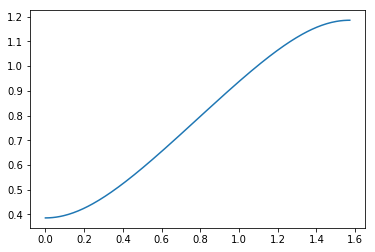

In [50]:
plt.plot(true_ord_angles[:251], obs_ord_angles[:251])

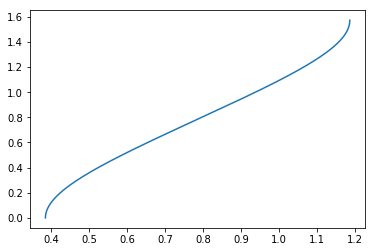

In [56]:
plt.plot( obs_ord_angles[:251],true_ord_angles[:251])

In [51]:
obs_ord_angles[249:251]

array([1.18557138, 1.1855917 ])

In [60]:
from scipy import interpolate
f = interpolate.interp1d(true_ord_angles,obs_ord_angles)
f_inv = interpolate.interp1d(
    obs_ord_angles[:251],
    true_ord_angles[:251],
    bounds_error=False,
    fill_value=(0,np.pi/2)
    )

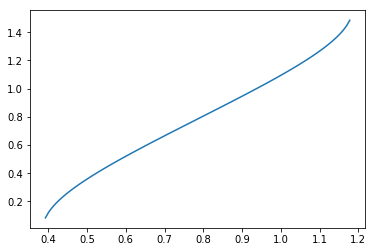

In [61]:
test_space = np.linspace(np.pi/8,np.pi/8*3,100)
plt.plot(test_space, f_inv(test_space))

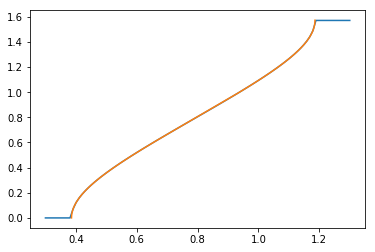

In [63]:
test_space = np.linspace(0.3,1.3,100)
plt.plot(test_space, f_inv(test_space))
plt.plot( obs_ord_angles[:251],true_ord_angles[:251])

(0.0, 0.2)

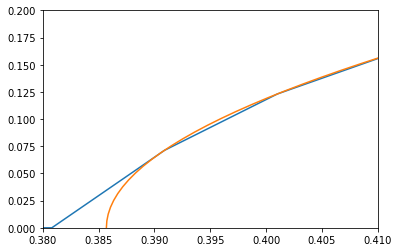

In [65]:
test_space = np.linspace(0.3,1.3,100)
plt.plot(test_space, f_inv(test_space))
plt.plot( obs_ord_angles[:251],true_ord_angles[:251])
plt.xlim([0.38,0.41])
plt.ylim([0.0,0.2])

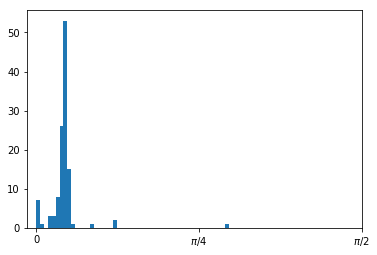

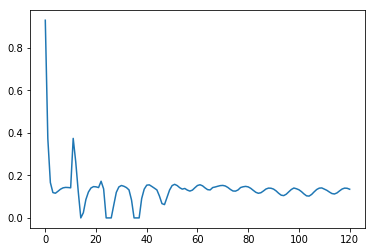

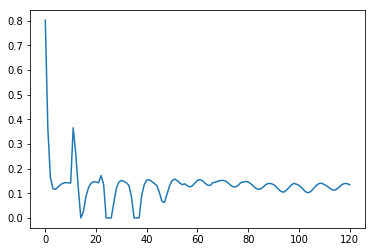

In [88]:
x_inv_mapped = f_inv(unnormed_observed_angles)
plt.hist(x_inv_mapped,50)
plt.xticks([0,np.pi/4,np.pi/2],[r'0',r'$\pi/4$',r'$\pi/2$'])
plt.figure()
plt.plot(x_inv_mapped)
plt.figure()
plt.plot(np.sin(x_inv_mapped))
# plt.figure()
# plt.plot(np.cos(x_inv_mapped)**2.+np.sin(x_inv_mapped)**2.)

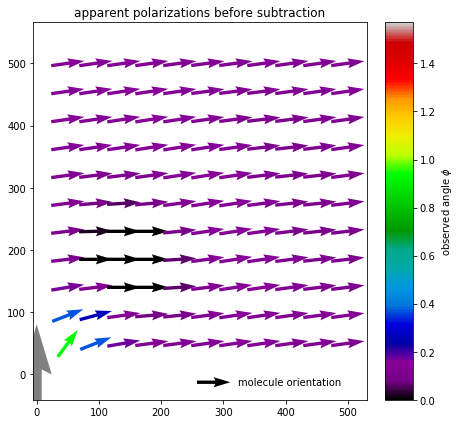

In [86]:


fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(6.5,6), 
                                   gridspec_kw = {'width_ratios':[6, 0.5]}
                                  )

quiv = ax0.quiver(x_plot, y_plot, 
                  np.cos(x_inv_mapped),
                  np.sin(x_inv_mapped), 
                  x_inv_mapped,
                  cmap=cmap,
                  clim = [0, np.pi/2], 
                  width=0.01,
                  scale=10,
        #            scale_units='width',
                  pivot='mid'
                  )
qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', labelpos='E',
                   coordinates='figure')

plas_mark = ax0.quiver(0, 0, 0,.3, color='grey',
#                        marker='o',
#                        s=2000
                       width=0.03,
                       scale=1,
                       units='width',
                       pivot='mid'
                      )
ax0.axis('equal')
ax0.set_xlim([-25, 550])
ax0.set_ylim([-25, 550])
ax0.set_title('apparent polarizations before subtraction')

norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'observed angle $\phi$')

fig.tight_layout()

In [83]:
f_inv(.39)

array(0.06473434)